# Analysis

This notebook analysis the results of the FL experiments, beginning with the first stage results. It will not only contain code and graphics, but also text describing the findings. This is in order to find the proper direction of research and to make writing the thesis chapter more easier afterwards.
The first stage analyses a wide range of FL models. The idea is to find similarities and differences between them. Therefore, this part heavily emphasizes on desprictive statistics of the collection of results.
The second stage focuses on specific results. The underlying model is more examined and potentential reasons for the unusual performances are considered. 

## Stage One - A Broad View on the Results 

In [1]:
#import libraries
import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt
import tikzplotlib
import statsmodels.api as sm

2023-02-21 17:29:31.868166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 17:29:34.241513: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-21 17:29:34.241654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-21 17:29:34.241662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#load data
df = pd.read_json("../logs.json")
df.head()

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,linear regression,weather,2,"[[1, 0.2146679336], [2, 0.2146679336]]",0.473040,"[[1, 14632.1585063], [2, 14632.1785786]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
1,1970-01-01,linearSVR,weather,2,"[[1, 0.2084263882], [2, 0.208519943]]",0.470466,"[[1, 14642.6542564], [2, 14642.7814292]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
2,1970-01-01,MLP,weather,2,"[[1, 0.22285768390000002], [2, 0.2294371277000...",0.510162,"[[1, 14655.3061747], [2, 14656.9484232]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2,16
3,1970-01-01,MLP,weather,2,"[[1, 0.2284306213], [2, 0.227299735]]",0.505609,"[[1, 14671.2134597], [2, 14672.4068422]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2,32
4,1970-01-01,MLP,weather,2,"[[1, 0.26731143890000003], [2, 0.2185005546]]",0.503282,"[[1, 14686.7712725], [2, 14688.767283]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,3,16


In [3]:
#print information
print(f"""
Length: {len(df.index)}
Covid entries: {len(df[df.dataset == "covid"].index)}
Weather entries: {len(df[df.dataset == "weather"].index)}
Contains Nans: {df.isnull().values.any()}
""")
#Nans are from Covid use cases, because the column "centralized_loss" is not used for this scenario


Length: 488
Covid entries: 108
Weather entries: 380
Contains Nans: True



In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rounds,488.0,3.663934,2.425432e+00,2.000000,2.00000,3.000000,4.000000,10.000000
centralized_loss,380.0,0.495668,1.854695e-02,0.468783,0.48493,0.495094,0.501634,0.636703
number_of_clients,488.0,4.401639,2.600458e+00,2.000000,3.00000,4.000000,5.000000,10.000000
entries,488.0,10.000000,0.000000e+00,10.000000,10.00000,10.000000,10.000000,10.000000
number_of_samples,488.0,29918.032787,3.740002e+04,10000.000000,10000.00000,10000.000000,10000.000000,100000.000000
percentage_of_testing_data,488.0,0.200000,2.778406e-17,0.200000,0.20000,0.200000,0.200000,0.200000
epochs,488.0,7.049180,3.863912e+00,2.000000,2.00000,10.000000,10.000000,10.000000
hidden_layers,488.0,3.081967,8.934180e-01,2.000000,2.00000,3.000000,4.000000,5.000000
batch_size,488.0,185.000000,3.237647e+02,16.000000,16.00000,32.000000,32.000000,1000.000000


The next part examines characteristics of each use case. 

### Weather dataset

In [5]:
#get horizontal use case
weather_df = df[df.dataset == "weather"]

In [6]:
#print general information
print(f"""
Linear Regression entries: {len(weather_df[weather_df.model == "linear regression"].index)}
LinearSVR entries: {len(weather_df[weather_df.model == "linearSVR"].index)}
MLP entries: {len(weather_df[weather_df.model == "MLP"].index)}
LSTM entries: {len(weather_df[weather_df.model == "LSTM"].index)}
CNN entries: {len(weather_df[weather_df.model == "CNN"].index)}
""")


Linear Regression entries: 10
LinearSVR entries: 10
MLP entries: 120
LSTM entries: 120
CNN entries: 120



The first interesting is to see how well the best model of every algorithm performed.

In [7]:
models = ["linear regression", "linearSVR", "MLP", "LSTM", "CNN"]
best_weather_performance = pd.DataFrame(columns=weather_df.columns)
for i, model in enumerate(models):
    df_copy = weather_df[weather_df.model == model].copy(deep=True)
    best_weather_performance = pd.concat([best_weather_performance, df_copy.sort_values(by=["centralized_loss"], ascending=True).iloc[0:1, :]], ignore_index=True)

best_weather_performance.head()
    

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,linear regression,weather,2,"[[1, 0.22633990810000001], [2, 0.2263399081000...",0.470925,"[[1, 18485.2237193], [2, 18485.2420305]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
1,1970-01-01,linearSVR,weather,2,"[[1, 0.2210292384], [2, 0.220997606]]",0.468783,"[[1, 18495.502747], [2, 18495.6092153]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
2,1970-01-01,MLP,weather,4,"[[1, 0.2583961735], [2, 0.22994924090000002], ...",0.485404,"[[1, 20241.8933053], [2, 20249.6347323], [3, 2...",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,4,16
3,1970-01-01,LSTM,weather,2,"[[1, 0.23243343330000002], [2, 0.2207945635]]",0.470519,"[[1, 19478.6567869], [2, 19547.4439425]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,4,16
4,1970-01-01,CNN,weather,2,"[[1, 0.2144570574], [2, 0.2081664801]]",0.475720,"[[1, 16043.744622], [2, 16054.7655888]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,4,16


The results match the expectations. The linear models can understand the underlying structure of the data. But the neural-network based models more capable in adapting to it. Interestingly, the MLP had the best performance. But in general the differences are minor.

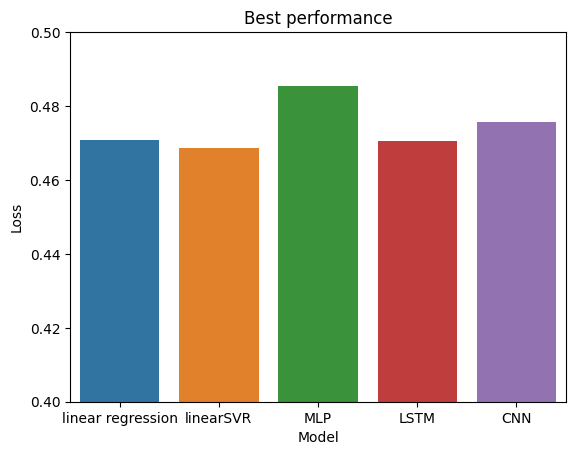

In [8]:
sns.barplot(data=best_weather_performance, x="model", y="centralized_loss")

plt.ylim((0.4, 0.5))
plt.ylabel("Loss")
plt.xlabel("Model")
plt.title("Best performance")

plt.show()

What is the average performance?

In [9]:
average_weather_performance = {"linear regression": 0, "linearSVR": 0, "MLP": 0, "LSTM": 0, "CNN": 0}
for  model in models:
    df_copy = weather_df[weather_df.model == model].copy(deep=True)
    average_weather_performance[model] = df_copy["centralized_loss"].mean()

average_weather_performance = pd.DataFrame(list(average_weather_performance.items()), columns=["model", "centralized_loss"])

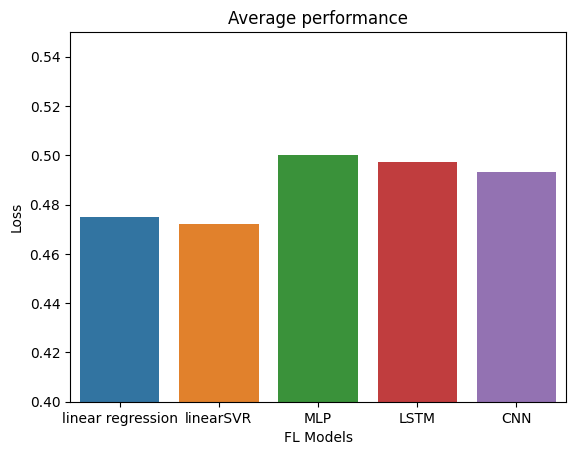

In [10]:
sns.barplot(average_weather_performance, x="model", y="centralized_loss")

plt.ylim((0.4,0.55))
plt.ylabel("Loss")
plt.xlabel("FL Models")
plt.title("Average performance")

plt.show()

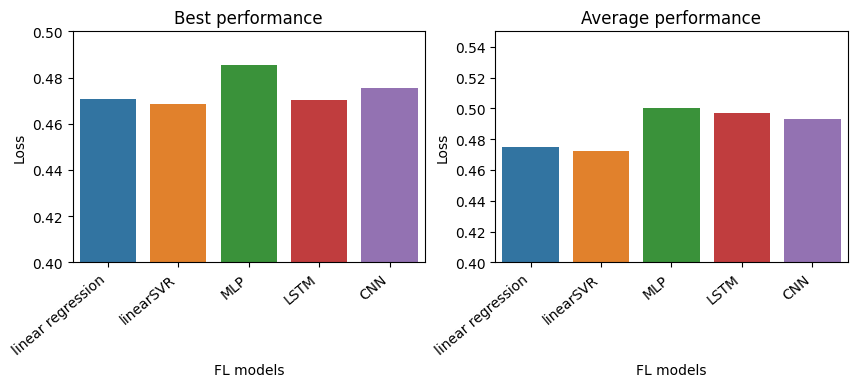

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

sns.barplot(data=best_weather_performance, x="model", y="centralized_loss", ax=axes[0])

axes[0].set_ylim((0.4, 0.5))
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("FL models")
axes[0].set_title("Best performance")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=40, ha="right")


sns.barplot(average_weather_performance, x="model", y="centralized_loss", ax=axes[1])

axes[1].set_ylim((0.4, 0.55))
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("FL models")
axes[1].set_title("Average performance")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=40, ha="right")

plt.savefig("exports/weather_fl_performance.svg")

plt.show()


The models performed almost identically on average. Next, it is interesting to see the variation in the data. Every record has a different parameter configuration. How "robust" are the algorithms?

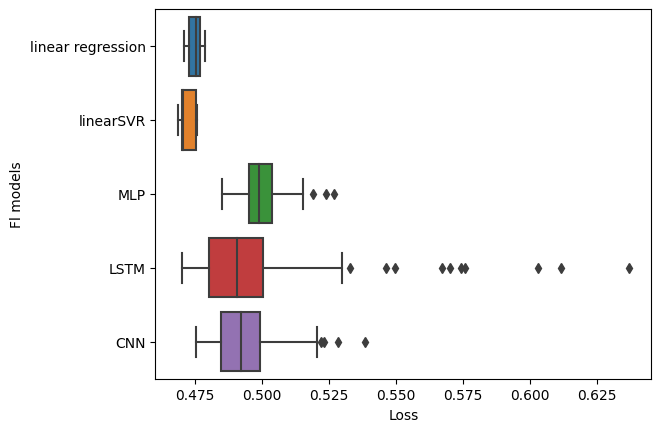

In [12]:
sns.boxplot(data=weather_df, x="centralized_loss", y="model")

plt.ylabel("Fl models")
plt.xlabel("Loss")

plt.savefig("exports/weather_fl_variance.svg")
plt.show()

How big is the difference between two and four clients?

In [13]:
print(f"""
Entries for two clients: {len(weather_df[weather_df.number_of_clients == 2].index)}
Entries for three clients: {len(weather_df[weather_df.number_of_clients == 3].index)}
Entries for four clients: {len(weather_df[weather_df.number_of_clients == 4].index)}
Entries for five clients: {len(weather_df[weather_df.number_of_clients == 5].index)}
Entries for ten clients: {len(weather_df[weather_df.number_of_clients == 10].index)}
""")


Entries for two clients: 76
Entries for three clients: 76
Entries for four clients: 76
Entries for five clients: 76
Entries for ten clients: 76



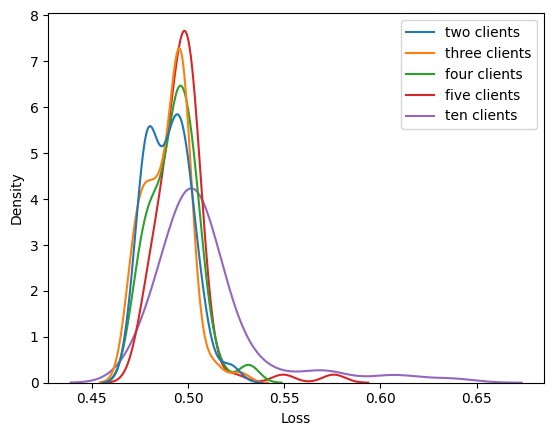

In [14]:
two_clients_df = weather_df[weather_df.number_of_clients == 2]
three_clients_df = weather_df[weather_df.number_of_clients == 3]
four_clients_df = weather_df[weather_df.number_of_clients == 4]
five_clients_df = weather_df[weather_df.number_of_clients == 5]
ten_clients_df = weather_df[weather_df.number_of_clients == 10]

num_of_clients_diff_df = pd.DataFrame({"two clients": two_clients_df.centralized_loss.to_numpy(), "three clients": three_clients_df.centralized_loss.to_numpy(), "four clients": four_clients_df.centralized_loss.to_numpy(), "five clients": five_clients_df.centralized_loss.to_numpy(), "ten clients": ten_clients_df.centralized_loss.to_numpy()})

sns.kdeplot(num_of_clients_diff_df)

plt.xlabel("Loss")
plt.savefig("exports/weather_fl_num_of_clients.svg")


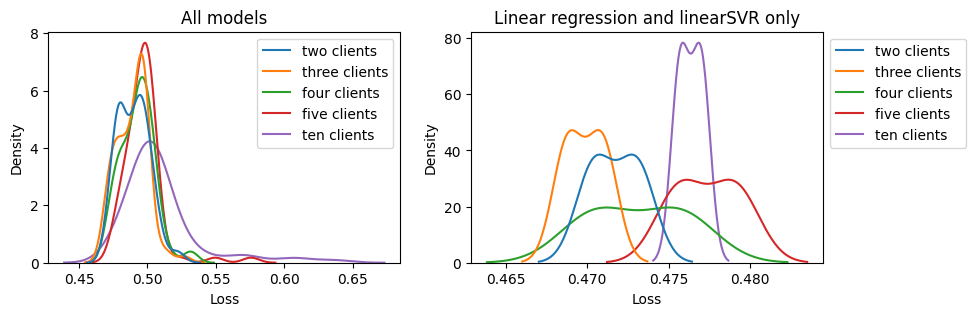

In [15]:
fig, axes = plt.subplots(1,2, figsize=(10,3))


two_clients_df = weather_df[weather_df.number_of_clients == 2]
three_clients_df = weather_df[weather_df.number_of_clients == 3]
four_clients_df = weather_df[weather_df.number_of_clients == 4]
five_clients_df = weather_df[weather_df.number_of_clients == 5]
ten_clients_df = weather_df[weather_df.number_of_clients == 10]

num_of_clients_diff_df = pd.DataFrame({"two clients": two_clients_df.centralized_loss.to_numpy(), "three clients": three_clients_df.centralized_loss.to_numpy(), "four clients": four_clients_df.centralized_loss.to_numpy(), "five clients": five_clients_df.centralized_loss.to_numpy(), "ten clients": ten_clients_df.centralized_loss.to_numpy()})

sns.kdeplot(num_of_clients_diff_df, ax=axes[0])

axes[0].set_xlabel("Loss")
axes[0].set_title("All models")


two_clients_df = weather_df[(weather_df.number_of_clients == 2) & ((weather_df.model == "linear regression") | (weather_df.model == "linearSVR"))]
three_clients_df = weather_df[(weather_df.number_of_clients == 3) & ((weather_df.model == "linear regression") | (weather_df.model == "linearSVR"))]
four_clients_df = weather_df[(weather_df.number_of_clients == 4) & ((weather_df.model == "linear regression") | (weather_df.model == "linearSVR"))]
five_clients_df = weather_df[(weather_df.number_of_clients == 5) & ((weather_df.model == "linear regression") | (weather_df.model == "linearSVR"))]
ten_clients_df = weather_df[(weather_df.number_of_clients == 10) & ((weather_df.model == "linear regression") | (weather_df.model == "linearSVR"))]

num_of_clients_diff_df = pd.DataFrame({"two clients": two_clients_df.centralized_loss.to_numpy(), "three clients": three_clients_df.centralized_loss.to_numpy(), "four clients": four_clients_df.centralized_loss.to_numpy(), "five clients": five_clients_df.centralized_loss.to_numpy(), "ten clients": ten_clients_df.centralized_loss.to_numpy()})

sns.kdeplot(num_of_clients_diff_df, ax=axes[1])

axes[1].set_xlabel("Loss")
axes[1].set_title("Linear regression and linearSVR only")
ax_legend = axes[1].get_legend()
ax_legend.set_bbox_to_anchor((1.0, 1.0))

plt.savefig("exports/weather_fl_num_of_clients.svg")
plt.show()

It looks like more clients acutally worsened the results. Let's perform some statistical tests to verify this assumption.

In [16]:
print("The Shapiro-Wilk test is conducted to check if the underlying distribution is a normal distribution")
for column in num_of_clients_diff_df:
    stat, p_value = scipy.stats.shapiro(num_of_clients_diff_df[column].to_numpy())
    print(f'The results from {column} have a likelihood of {p_value} to be sampled from a normal distribution.')

The Shapiro-Wilk test is conducted to check if the underlying distribution is a normal distribution
The results from two clients have a likelihood of 0.02745779976248741 to be sampled from a normal distribution.
The results from three clients have a likelihood of 0.031125415116548538 to be sampled from a normal distribution.
The results from four clients have a likelihood of 0.0324845090508461 to be sampled from a normal distribution.
The results from five clients have a likelihood of 0.033554963767528534 to be sampled from a normal distribution.
The results from ten clients have a likelihood of 0.025285616517066956 to be sampled from a normal distribution.


None of these results indicate an underlying normal distribution. The Mann-Whitney U test can be used to test the mean of the distributions.

In [17]:
print("The Mann-Whitney U test is used to examine the differences in the mean for the underlying distributions.")
#two/ten
stat, p_value = scipy.stats.mannwhitneyu(num_of_clients_diff_df["two clients"].to_numpy(), num_of_clients_diff_df["ten clients"].to_numpy(), alternative="less")
print(f'The underlying distribution for two clients sample has a likelihood of {1-p_value} to have a smaller mean than that of ten samples.')

#two/five
stat, p_value = scipy.stats.mannwhitneyu(num_of_clients_diff_df["two clients"].to_numpy(), num_of_clients_diff_df["five clients"].to_numpy(), alternative="less")
print(f'The underlying distribution for two clients sample has a likelihood of {1-p_value} to have a smaller mean than that of five samples.')

#two/four
stat, p_value = scipy.stats.mannwhitneyu(num_of_clients_diff_df["two clients"].to_numpy(), num_of_clients_diff_df["four clients"].to_numpy(), alternative="less")
print(f'The underlying distribution for two clients sample has a likelihood of {1-p_value} to have a smaller mean than that of four samples.')

#two/three
stat, p_value = scipy.stats.mannwhitneyu(num_of_clients_diff_df["two clients"].to_numpy(), num_of_clients_diff_df["three clients"].to_numpy(), alternative="less")
print(f'The underlying distribution for two clients sample has a likelihood of {1-p_value} to have a smaller mean than that of three samples.')

The Mann-Whitney U test is used to examine the differences in the mean for the underlying distributions.
The underlying distribution for two clients sample has a likelihood of 0.9857852320006018 to have a smaller mean than that of ten samples.
The underlying distribution for two clients sample has a likelihood of 0.9857852320006018 to have a smaller mean than that of five samples.
The underlying distribution for two clients sample has a likelihood of 0.846753917479208 to have a smaller mean than that of four samples.
The underlying distribution for two clients sample has a likelihood of 0.09429115275951805 to have a smaller mean than that of three samples.


The tests show that the results grouped for different clients are not normally distributed. It seems the lower the number of clients, the smaller the test loss. 

The NN have a large variance. This question is asked again in the second stage with more linear models trained.

Do the number of rounds impact the model performance?

In [18]:
print(f"""
Samples for two rounds: {len(weather_df[weather_df.rounds == 2].index)}
Samples for four rounds: {len(weather_df[weather_df.rounds == 4].index)}
""")


Samples for two rounds: 190
Samples for four rounds: 190



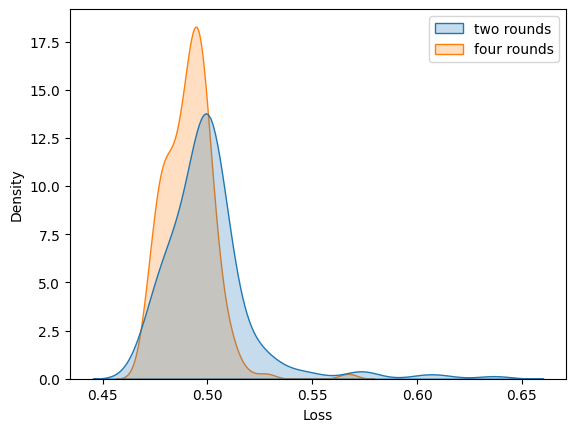

In [19]:
two_rounds_df = weather_df[weather_df.rounds == 2]
four_rounds_df = weather_df[weather_df.rounds == 4]

num_of_rounds_diff_df = pd.DataFrame({"two rounds": two_rounds_df.centralized_loss, "four rounds": four_rounds_df.centralized_loss})

sns.kdeplot(num_of_rounds_diff_df, fill=True)
plt.xlabel("Loss")

plt.savefig("exports/weather_fl_num_of_rounds.svg")
plt.show()

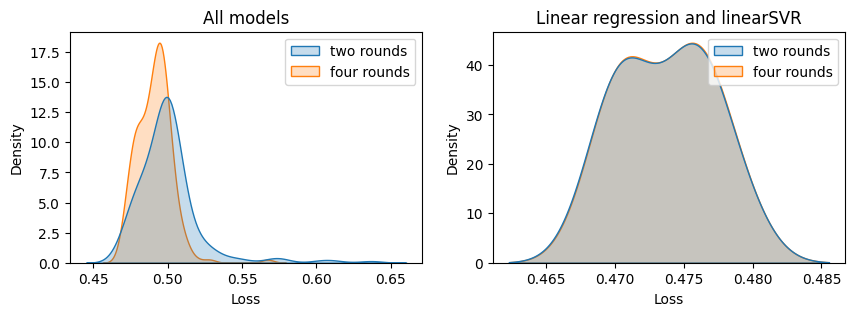

In [20]:
fig, axes = plt.subplots(1,2, figsize=(10,3))


two_rounds_df = weather_df[weather_df.rounds == 2]
four_rounds_df = weather_df[weather_df.rounds == 4]

num_of_rounds_diff_df = pd.DataFrame({"two rounds": two_rounds_df.centralized_loss, "four rounds": four_rounds_df.centralized_loss})

sns.kdeplot(num_of_rounds_diff_df, fill=True, ax=axes[0])

axes[0].set_xlabel("Loss")
axes[0].set_title("All models")


two_rounds_df = weather_df[(weather_df.rounds == 2) & ((weather_df.model == "linear regression") | (weather_df.model == "linearSVR"))]
four_rounds_df = weather_df[(weather_df.rounds == 4) & ((weather_df.model == "linear regression") | (weather_df.model == "linearSVR"))]

num_of_rounds_diff_df = pd.DataFrame({"two rounds": two_rounds_df.centralized_loss, "four rounds": four_rounds_df.centralized_loss})

sns.kdeplot(num_of_rounds_diff_df, fill=True, ax=axes[1])

axes[1].set_xlabel("Loss")
axes[1].set_title("Linear regression and linearSVR")

#plt.savefig("exports/weather_fl_num_of_clients.svg")
plt.show()

Are the results normally distributed?

In [21]:
two_rounds_df = weather_df[weather_df.rounds == 2]
four_rounds_df = weather_df[weather_df.rounds == 4]

In [22]:
print("The Shapiro-Wilk test is conducted to check if the underlying distribution is a normal distribution")

stat, p_value = scipy.stats.shapiro(two_rounds_df.centralized_loss.to_numpy())
print(f'The samples from two rounds have a likelihood of {p_value} to be sampled from a normal distribution')

stat, p_value = scipy.stats.shapiro(four_rounds_df.centralized_loss.to_numpy())
print(f'The samples from two rounds have a likelihood of {p_value} to be sampled from a normal distribution')

The Shapiro-Wilk test is conducted to check if the underlying distribution is a normal distribution
The samples from two rounds have a likelihood of 7.554940304700791e-17 to be sampled from a normal distribution
The samples from two rounds have a likelihood of 2.2042556668822044e-09 to be sampled from a normal distribution


In [23]:
stat, p_value = scipy.stats.mannwhitneyu(four_rounds_df.centralized_loss.to_numpy(), two_rounds_df.centralized_loss.to_numpy(), alternative="less")

print(f"""
Samples of two rounds have a mean of {two_rounds_df.centralized_loss.mean()}, {four_rounds_df.centralized_loss.mean()} for four rounds.
The distribution for four rounds has a likelihood of {1-p_value} to have a smaller mean than that of two rounds, according to the Mann-Whitney U test.
""")


Samples of two rounds have a mean of 0.5003207300599999, 0.4910155736463158 for four rounds.
The distribution for four rounds has a likelihood of 0.9999999819647469 to have a smaller mean than that of two rounds, according to the Mann-Whitney U test.



In [24]:
stat, p_value = scipy.stats.levene(four_rounds_df.centralized_loss.to_numpy(), two_rounds_df.centralized_loss.to_numpy())

print(p_value)

0.003606682612759257


The number of rounds seems to have an impact on performance. The average is almost the same, but the tails are different. Two rounds has a fat tail on the right. What the skew and kurosis of the distributions?

In [25]:
print(f"""
Two rounds skew: {two_rounds_df.centralized_loss.skew()}
Two rounds kurosis: {two_rounds_df.centralized_loss.kurtosis()}
Four rounds skew: {four_rounds_df.centralized_loss.skew()}
Four rounds kurtosis: {four_rounds_df.centralized_loss.kurtosis()}
""")


Two rounds skew: 2.8675185975073405
Two rounds kurosis: 12.387065367119503
Four rounds skew: 1.4542013969889247
Four rounds kurtosis: 8.13428342644458



Both types of training have a positive skewness.
The kurtosis is extremely high for both of them. The two rounds excess kurtosis is at around 9.39 and the four round excess kurtosis is at around 5.13. Both of them are leptokurtic.

Next, let's look at the average training time.

In [26]:
def calculate_training_time(time_array):
    #get the timestamps
    timestamps = []
    for el in time_array:
        timestamps.append(el[-1])
    
    #calculate difference
    diff = []
    for i in range(len(timestamps)):
        if i == len(timestamps)-1:
            break
        diff.append((timestamps[i+1] - timestamps[i]))
    return diff

time_diff_df = weather_df.copy(deep=True)
time_diff_df["time"] = time_diff_df["time"].apply(calculate_training_time)

In [27]:
time_average_df = time_diff_df
time_average_df["time"] = time_average_df["time"].apply(lambda x: np.array(x).mean())

In [28]:
average_time_performance = {"linear regression": 0, "linearSVR": 0, "MLP": 0, "LSTM": 0, "CNN": 0}
for  model in models:
    df = time_average_df[time_average_df.model == model]
    average_time_performance[model] = df["time"].mean()

average_time_performance = pd.DataFrame(list(average_time_performance.items()), columns=["model", "time"])
average_time_performance.head()

,model,time
0,linear regression,0.025216
1,linearSVR,0.091444
2,MLP,3.717121
3,LSTM,30.428448
4,CNN,5.990096


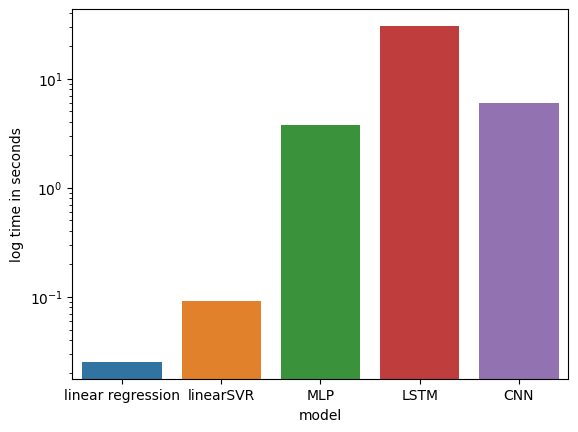

In [29]:
plot = sns.barplot(average_time_performance, x="model", y="time")

plt.yscale("log")
plt.yticks([0.1, 1, 10])
plt.ylabel("log time in seconds")

plt.savefig("exports/weather_fl_time.svg")

plt.show()

In [30]:
print(f'The training of a linear regression model is {average_time_performance.time.iloc[3] / average_time_performance.time.iloc[0]} times faster than that of a LSTM.')

The training of a linear regression model is 1206.7355550913283 times faster than that of a LSTM.


How big is the variance in training time?

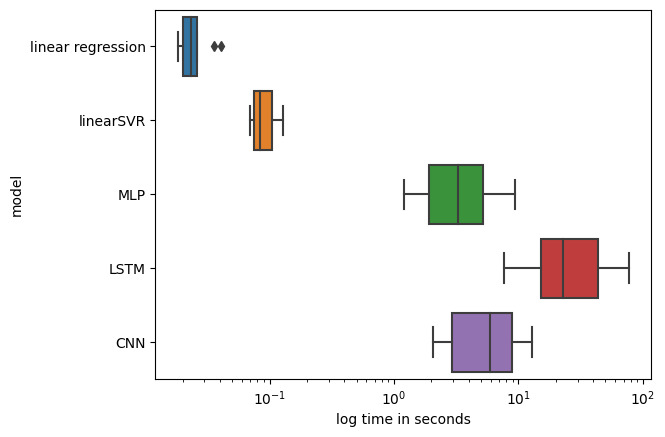

In [31]:
sns.boxplot(data=time_diff_df, x="time", y="model")
plt.xscale("log")
plt.xlabel("log time in seconds")

plt.show()

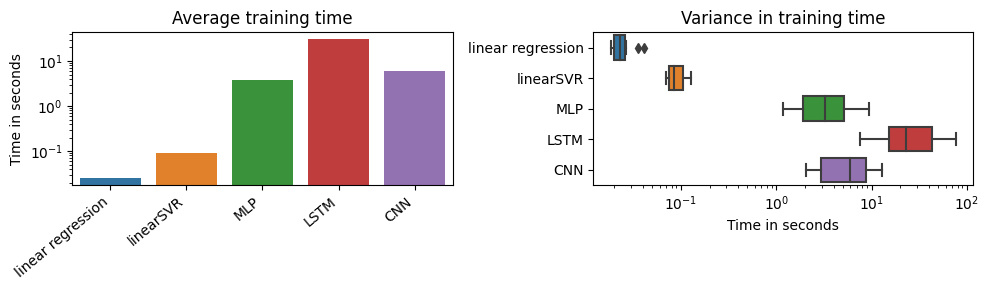

In [32]:
fig, axes = plt.subplots(1,2, figsize=(10,3))


sns.barplot(average_time_performance, x="model", y="time", ax=axes[0])

axes[0].set_yscale("log")
axes[0].set_ylabel("Time in seconds")
axes[0].set_xlabel("")
axes[0].set_title("Average training time")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=40, ha="right")


sns.boxplot(data=time_diff_df, x="time", y="model", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_xlabel("Time in seconds")
axes[1].set_ylabel("")
axes[1].set_title("Variance in training time")

fig.tight_layout() 

plt.savefig("exports/weather_fl_time.svg")
plt.show()


Now lets compare the models with the baseline. First, all FL models are compared to the baselines. It is likely they perform worse on average because of their hyperparameters. After that the best models, as well as the models with optimal hyperparameters are selected, trained multiple times to minimize the effect of random initialization and then compared. 

In [33]:
import json

with open('exports/weather_baselines.json') as data:
    baselines = json.load(data)
    data.close()

In [34]:
dfs = []
for model, data in baselines.items():
    df = pd.DataFrame.from_dict(data)
    df['model'] = model
    dfs.append(df)

baseline_df = pd.concat(dfs, axis=0, ignore_index=True)
baseline_df.head()

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4,client_data5,client_time5,client_data10,client_time10,model
0,0.468485,0.018343,0.472588,0.015448,0.470617,0.016760,0.474687,0.015586,0.478073,0.021640,0.475418,0.015522,linear_regression
1,0.468485,0.010407,0.472588,0.021814,0.470617,0.015130,0.474687,0.014739,0.478073,0.013503,0.475418,0.022154,linear_regression
2,0.468485,0.018579,0.472588,0.018618,0.470617,0.014893,0.474687,0.014351,0.478073,0.015173,0.475418,0.016292,linear_regression
3,0.468485,0.011517,0.472588,0.015809,0.470617,0.015005,0.474687,0.016217,0.478073,0.023065,0.475418,0.014036,linear_regression
4,0.470837,0.272237,0.471202,0.289606,0.467806,0.324249,0.468912,0.334001,0.471405,0.305503,0.469755,0.303055,linearSVR


In [35]:
baseline_averages = baseline_df.groupby("model").mean()
baseline_averages

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4,client_data5,client_time5,client_data10,client_time10
model,,,,,,,,,,,,
CNN,0.481297,9.452085,0.483557,9.379620,0.480593,9.145430,0.480728,8.838757,0.485225,8.707742,0.481992,8.515856
LSTM,0.475554,34.581762,0.478579,38.159104,0.477270,42.853293,0.478657,39.434842,0.481268,42.208679,0.480001,38.703621
MLP,0.496039,11.898799,0.497680,11.528268,0.499729,12.017267,0.494212,11.651702,0.496600,11.591530,0.496689,11.530619
linearSVR,0.470804,0.316822,0.471114,0.285790,0.467835,0.323791,0.468837,0.333164,0.471495,0.314515,0.469729,0.308507
linear_regression,0.468485,0.014712,0.472588,0.017922,0.470617,0.015447,0.474687,0.015223,0.478073,0.018345,0.475418,0.017001


<AxesSubplot: ylabel='Density'>

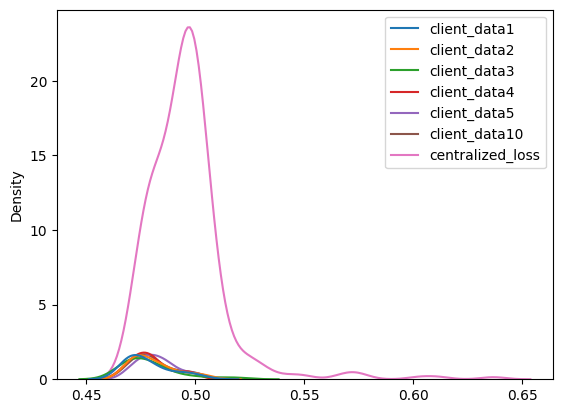

In [36]:
temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(lambda x: f'{x} basline')
#fig = sns.boxplot(temp_df, x="client_data4", y="model")
#fig = sns.boxplot(results_only_df, x="losses_distributed", y="model")
#plt.show()

fig, ax = plt.subplots()
sns.kdeplot(data=[temp_df["client_data1"], temp_df["client_data2"], temp_df["client_data3"], temp_df["client_data4"], temp_df["client_data5"], temp_df["client_data10"], weather_df["centralized_loss"]], ax=ax)

In [37]:
print(f"""
Mean baseline for data of 1 client: {baseline_averages["client_data1"].mean()}
Mean baseline for data of 2 clients: {baseline_averages["client_data2"].mean()}
Mean baseline for data of 3 clients: {baseline_averages["client_data3"].mean()}
Mean baseline for data of 4 clients: {baseline_averages["client_data4"].mean()}
Mean baseline for data of 5 clients: {baseline_averages["client_data5"].mean()}
Mean baseline for data of 10 clients: {baseline_averages["client_data10"].mean()}
------------------------------------------------------------------------------
Mean for FL with 2 clients: {two_clients_df["centralized_loss"].mean()}
Mean for FL with 4 clients: {four_clients_df["centralized_loss"].mean()}
""")


Mean baseline for data of 1 client: 0.47843569158400756
Mean baseline for data of 2 clients: 0.48070373120997206
Mean baseline for data of 3 clients: 0.4792089745952638
Mean baseline for data of 4 clients: 0.47942434509235304
Mean baseline for data of 5 clients: 0.48253223631796
Mean baseline for data of 10 clients: 0.4807658420430722
------------------------------------------------------------------------------
Mean for FL with 2 clients: 0.4717442264
Mean for FL with 4 clients: 0.47311264685000004



The best results seem to be from the baseline that used only one dataset. How do the baseline distributions look like?

<AxesSubplot: ylabel='Density'>

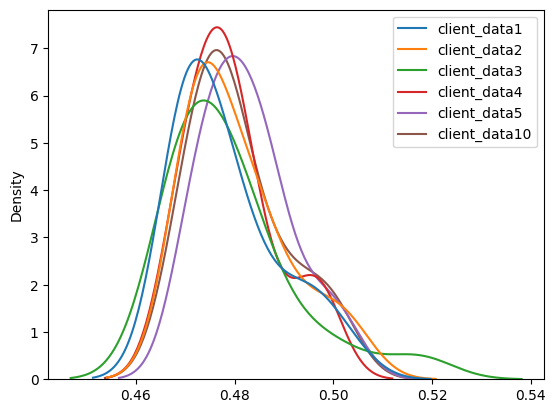

In [38]:
fig, ax = plt.subplots()
sns.kdeplot(data=[temp_df["client_data1"], temp_df["client_data2"], temp_df["client_data3"], temp_df["client_data4"], temp_df["client_data5"], temp_df["client_data10"]], ax=ax)

In [39]:
stat, p_value = scipy.stats.mannwhitneyu(baseline_averages.client_data2.to_numpy(), baseline_averages.client_data1.to_numpy(), alternative="less")
print(f'The underlying distribution for models trained on one dataset sample has a likelihood of {1-p_value} to have a smaller mean than that of models trained on two datasets.')


The underlying distribution for models trained on one dataset sample has a likelihood of 0.21031746031746046 to have a smaller mean than that of models trained on two datasets.


The data suggests that combining data from multiple weather stations and training them centrally actually decreases the accuracy of the model. This does not seem to be the case for the FL setting. How does the skewness and kurosis looks for the distributions?

In [40]:
baseline_fl_dist_df = pd.DataFrame(([["Baseline 1 clients data", baseline_averages["client_data1"].mean(), baseline_averages["client_data1"].std(), baseline_averages["client_data1"].skew(), baseline_averages["client_data1"].kurtosis()],
    ["Baseline 2 clients data", baseline_averages["client_data2"].mean(), baseline_averages["client_data2"].std(), baseline_averages["client_data2"].skew(), baseline_averages["client_data2"].kurtosis()],
    ["FL with 2 clients", two_clients_df["centralized_loss"].mean(), two_clients_df["centralized_loss"].std(), two_clients_df["centralized_loss"].skew(), two_clients_df["centralized_loss"].kurtosis()],
    ["Baseline 3 clients data", baseline_averages["client_data3"].mean(), baseline_averages["client_data3"].std(), baseline_averages["client_data3"].skew(), baseline_averages["client_data3"].kurtosis()],
    ["FL with 3 clients", three_clients_df["centralized_loss"].mean(), three_clients_df["centralized_loss"].std(), three_clients_df["centralized_loss"].skew(), three_clients_df["centralized_loss"].kurtosis()],
    ["Baseline 4 clients data", baseline_averages["client_data4"].mean(), baseline_averages["client_data4"].std(), baseline_averages["client_data4"].skew(), baseline_averages["client_data4"].kurtosis()],
    ["FL with 4 clients", four_clients_df["centralized_loss"].mean(), four_clients_df["centralized_loss"].std(), four_clients_df["centralized_loss"].skew(), four_clients_df["centralized_loss"].kurtosis()],
    ["Baseline 5 clients data", baseline_averages["client_data5"].mean(), baseline_averages["client_data5"].std(), baseline_averages["client_data5"].skew(), baseline_averages["client_data5"].kurtosis()],
    ["FL with 5 clients", five_clients_df["centralized_loss"].mean(), five_clients_df["centralized_loss"].std(), five_clients_df["centralized_loss"].skew(), five_clients_df["centralized_loss"].kurtosis()],
    ["Baseline 10 clients data", baseline_averages["client_data10"].mean(), baseline_averages["client_data10"].std(), baseline_averages["client_data10"].skew(), baseline_averages["client_data10"].kurtosis()],
    ["FL with 10 clients", ten_clients_df["centralized_loss"].mean(), ten_clients_df["centralized_loss"].std(), ten_clients_df["centralized_loss"].skew(), ten_clients_df["centralized_loss"].kurtosis()]
]), columns=["scenario", "mean", "std", "skew", "kurtosis"])

baseline_fl_dist_df

,scenario,mean,std,skew,kurtosis
0,Baseline 1 clients data,0.478436,0.010996,1.261313,1.350812
1,Baseline 2 clients data,0.480704,0.010708,1.184215,1.120410
2,FL with 2 clients,0.471744,0.001497,-0.000487,-5.997186
3,Baseline 3 clients data,0.479209,0.012549,1.376784,2.055339
4,FL with 3 clients,0.469868,0.001221,-0.001817,-5.989510
5,Baseline 4 clients data,0.479424,0.009427,0.966121,1.636466
6,FL with 4 clients,0.473113,0.002931,-0.002483,-5.985665
7,Baseline 5 clients data,0.482532,0.009334,0.701359,0.970036
8,FL with 5 clients,0.477399,0.001951,-0.003065,-5.982304
9,Baseline 10 clients data,0.480766,0.010075,1.035332,1.697574


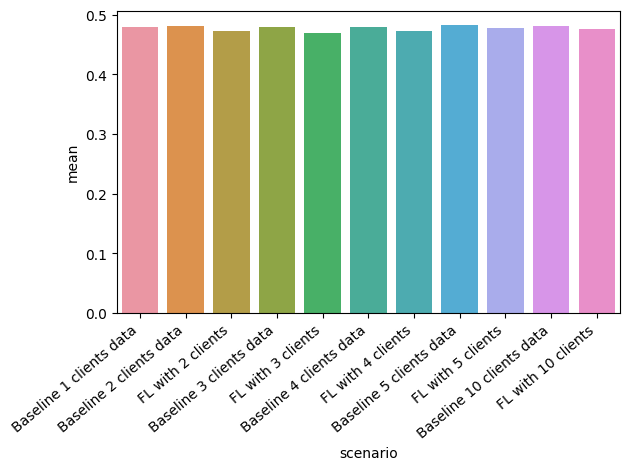

In [41]:
ax = sns.barplot(baseline_fl_dist_df, x="scenario", y="mean")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [42]:
time_diff_df.head()

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,linear regression,weather,2,"[[1, 0.2146679336], [2, 0.2146679336]]",0.473040,0.020072,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
1,1970-01-01,linearSVR,weather,2,"[[1, 0.2084263882], [2, 0.208519943]]",0.470466,0.127173,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
2,1970-01-01,MLP,weather,2,"[[1, 0.22285768390000002], [2, 0.2294371277000...",0.510162,1.642249,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2,16
3,1970-01-01,MLP,weather,2,"[[1, 0.2284306213], [2, 0.227299735]]",0.505609,1.193382,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2,32
4,1970-01-01,MLP,weather,2,"[[1, 0.26731143890000003], [2, 0.2185005546]]",0.503282,1.996010,2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,3,16


## Stage Two - Comparing the Performances to the Baselines

This section compares the baselines to individual FL model configurations. Two types of FL configurations are considered. The first one uses the same hyperparameters as the baselines, the second one are the models with the best recorded loss. Every FL model gets trained five times again to minimize the effect of random initialization.

In [43]:
fl_models_df = pd.read_json("../weather_best_model_logs.json")

In [44]:
fl_models_df.head()

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,linear regression,weather,2,"[[1, 0.22633990810000001], [2, 0.2263399081000...",0.470925,"[[1, 13794.4501722], [2, 13794.468864]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
1,1970-01-01,linear regression,weather,2,"[[1, 0.22633990810000001], [2, 0.2263399081000...",0.470925,"[[1, 13804.9768598], [2, 13804.9964318]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
2,1970-01-01,linear regression,weather,2,"[[1, 0.22633990810000001], [2, 0.2263399081000...",0.470925,"[[1, 13817.4795099], [2, 13817.5385498]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
3,1970-01-01,linear regression,weather,2,"[[1, 0.22633990810000001], [2, 0.2263399081000...",0.470925,"[[1, 13829.7875486], [2, 13829.8099433]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32
4,1970-01-01,linearSVR,weather,2,"[[1, 0.22103623630000002], [2, 0.2210272482]]",0.468815,"[[1, 13841.8221262], [2, 13841.9695163]]",3,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5,32


In [45]:
baseline_df.head()

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4,client_data5,client_time5,client_data10,client_time10,model
0,0.468485,0.018343,0.472588,0.015448,0.470617,0.016760,0.474687,0.015586,0.478073,0.021640,0.475418,0.015522,linear_regression
1,0.468485,0.010407,0.472588,0.021814,0.470617,0.015130,0.474687,0.014739,0.478073,0.013503,0.475418,0.022154,linear_regression
2,0.468485,0.018579,0.472588,0.018618,0.470617,0.014893,0.474687,0.014351,0.478073,0.015173,0.475418,0.016292,linear_regression
3,0.468485,0.011517,0.472588,0.015809,0.470617,0.015005,0.474687,0.016217,0.478073,0.023065,0.475418,0.014036,linear_regression
4,0.470837,0.272237,0.471202,0.289606,0.467806,0.324249,0.468912,0.334001,0.471405,0.305503,0.469755,0.303055,linearSVR


How well have the FL models preformed compared to the baseline? 

In [46]:
def rename_baseline_models(x):
    if x == "linear_regression":
        return "linear regression baseline"
    elif x == "linearSVR":
        return "linearSVR baseline"
    elif x == "MLP":
        return "MLP baseline"
    elif x == "LSTM":
        return "LSTM baseline"
    else:
        return "CNN baseline"

In [47]:
baseline_three_clients = baseline_df.copy(deep=True)
baseline_three_clients["model"] = baseline_three_clients["model"].apply(rename_baseline_models)
baseline_three_clients = baseline_three_clients[["model", "client_data3"]]
baseline_three_clients.columns = ["model", "centralized_loss"]

#remove CNN since 3 clients was not optimal for this architecture
baseline_three_clients = baseline_three_clients[baseline_three_clients.model != "CNN baseline"]


baseline_cnn_two_clients = baseline_df.copy(deep=True)
baseline_cnn_two_clients["model"] = baseline_cnn_two_clients["model"].apply(rename_baseline_models)
baseline_cnn_two_clients = baseline_cnn_two_clients[["model", "client_data2"]]
baseline_cnn_two_clients.columns = ["model", "centralized_loss"]
baseline_cnn_two_clients = baseline_cnn_two_clients[baseline_cnn_two_clients.model == "CNN baseline"]

best_fl_df = fl_models_df.copy(deep=True)
best_fl_df["model"] = best_fl_df["model"].apply(lambda x: f"best FL {x}")

In [48]:
temp_df = pd.concat([baseline_three_clients, baseline_cnn_two_clients, best_fl_df], ignore_index=True)

temp_df = temp_df[["model", "centralized_loss"]]
temp_df.columns = ["model", "loss"]

<AxesSubplot: xlabel='loss', ylabel='model'>

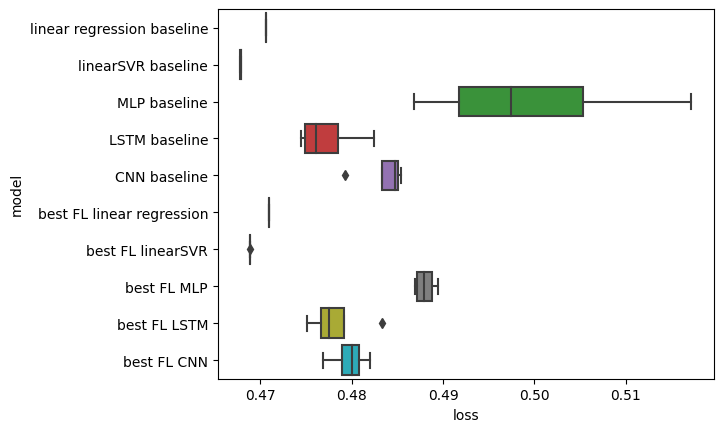

In [49]:
sns.boxplot(temp_df, x="loss", y="model")

In [50]:
temp_df.groupby(by="model").agg(["mean", "var"]).to_latex("exports/weather_results_table.tex")

/tmp/ipykernel_240/707128296.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  temp_df.groupby(by="model").agg(["mean", "var"]).to_latex("exports/weather_results_table.tex")


The all FL models beat the baseline models. The FL MLPs and CNNs are also really interesting. "best FL MLP/CNN" hyperparameters are based on the best performing models during the FL test run. "optimal FL MLP/CNN" are use the optimal hyperparameters found by the centralized hyperparameter tuning. The difference between the models is only minimal, despite them having a different amount of hidden layers, and likely due to the random initialization. The "optimal FL MLP" is a little better than "best FL MLP" but has a higher variance.

It seems FL produces better models than centralized training with multiple combined datasets. How well does FL perform when compared to centralized training with less combined datasets? 

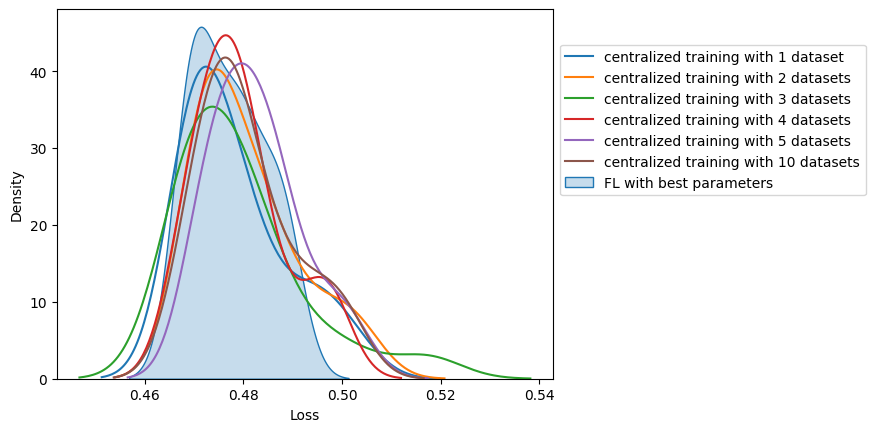

In [51]:
fig = sns.kdeplot(baseline_df["client_data1"], label="centralized training with 1 dataset")
fig = sns.kdeplot(baseline_df["client_data2"], label="centralized training with 2 datasets")
fig = sns.kdeplot(baseline_df["client_data3"], label="centralized training with 3 datasets")
fig = sns.kdeplot(baseline_df["client_data4"], label="centralized training with 4 datasets")
fig = sns.kdeplot(baseline_df["client_data5"], label="centralized training with 5 datasets")
fig = sns.kdeplot(baseline_df["client_data10"], label="centralized training with 10 datasets")
fig = sns.kdeplot(best_fl_df["centralized_loss"], fill=True, label="FL with best parameters")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xlabel("Loss")
plt.savefig("exports/weather_fl_results.svg")
plt.show()

In [52]:
best_fl_dist_df = pd.DataFrame(([
    ["FL with best parameters", best_fl_df["centralized_loss"].mean(), best_fl_df["centralized_loss"].std(), best_fl_df["centralized_loss"].skew(), best_fl_df["centralized_loss"].kurtosis()]
]), columns=["scenario", "mean", "std", "skew", "kurtosis"])

baseline_and_best_fl_dist_df = pd.concat([baseline_fl_dist_df[baseline_fl_dist_df["scenario"].str.startswith("Baseline")], best_fl_dist_df], ignore_index=True)

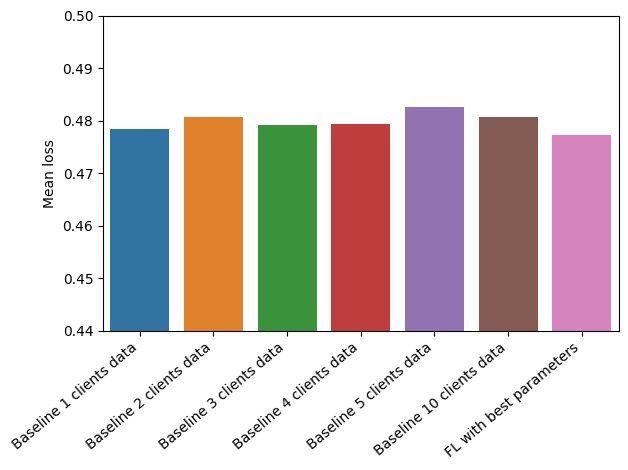

In [53]:
ax = sns.barplot(baseline_and_best_fl_dist_df, x="scenario", y="mean")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.ylim((0.44, 0.5))
plt.xlabel("")
plt.ylabel("Mean loss")

plt.tight_layout()

plt.savefig("exports/weather_fl_results_barplot.svg")
plt.show()

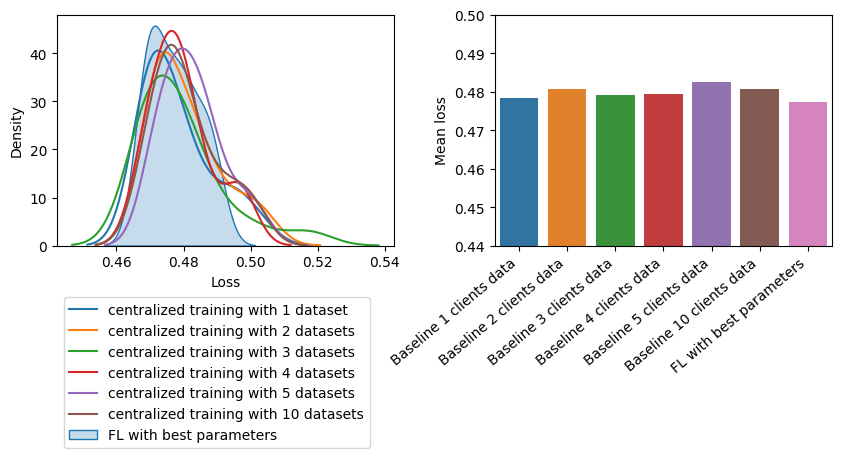

In [54]:
subplot_fig, axes = plt.subplots(1,2, figsize=(10,3))

fig = sns.kdeplot(baseline_df["client_data1"], label="centralized training with 1 dataset", ax=axes[0])
fig = sns.kdeplot(baseline_df["client_data2"], label="centralized training with 2 datasets", ax=axes[0])
fig = sns.kdeplot(baseline_df["client_data3"], label="centralized training with 3 datasets", ax=axes[0])
fig = sns.kdeplot(baseline_df["client_data4"], label="centralized training with 4 datasets", ax=axes[0])
fig = sns.kdeplot(baseline_df["client_data5"], label="centralized training with 5 datasets", ax=axes[0])
fig = sns.kdeplot(baseline_df["client_data10"], label="centralized training with 10 datasets", ax=axes[0])
fig = sns.kdeplot(best_fl_df["centralized_loss"], fill=True, label="FL with best parameters", ax=axes[0])

axes[0].set_xlabel("Loss")
axes[0].legend(bbox_to_anchor=(0, -0.55), loc='center left', ncol=1)


ax = sns.barplot(baseline_and_best_fl_dist_df, x="scenario", y="mean", ax=axes[1], hue=None)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

axes[1].set_ylim((0.44, 0.5))
axes[1].set_xlabel("")
axes[1].set_ylabel("Mean loss")

plt.subplots_adjust(wspace=0.3)

plt.show()

The FL scenario has the lowest loss, but it is really close to the baseline with one dataset. Is there a statistcal siginifcant difference?

In [58]:
stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data1"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'The p-value for testing if the best FL results and centralized training with one dataset are sampled from the same distribution is {p_value}')
if p_value < 0.05: #5% alpha
    print("The hypothesis is rejected")
else:
    print("The hypothesis cannot be rejected.")

stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data3"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'The p-value for testing if the best FL results and centralized training with three datasets are sampled from the same distribution is {p_value}')
if p_value < 0.05: #5% alpha
    print("The hypothesis is rejected")
else:
    print("The hypothesis cannot be rejected.")

The p-value for testing if the best FL results and centralized training with one dataset are sampled from the same distribution is 0.7555206868432192
The hypothesis cannot be rejected.
The p-value for testing if the best FL results and centralized training with three datasets are sampled from the same distribution is 0.7350288083519299
The hypothesis cannot be rejected.


In [59]:
stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data1"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 1: {p_value}')

stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data2"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 2: {p_value}')

stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data3"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 3: {p_value}')

stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data4"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 4: {p_value}')

stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data5"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 5: {p_value}')

stat, p_value = scipy.stats.mannwhitneyu(baseline_df["client_data10"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 10: {p_value}')

Client 1: 0.7555206868432192
Client 2: 0.16320039250613394
Client 3: 0.7350288083519299
Client 4: 0.6356273782910724
Client 5: 0.04093376761128674
Client 10: 0.30994795069834835


The FL results and baseline results are to similar to reject the null hypothesis.

In [63]:
baseline_and_best_fl_dist_df.to_latex("exports/weather_moments_table.tex")

/tmp/ipykernel_240/3425589707.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  baseline_and_best_fl_dist_df.to_latex("exports/weather_moments_table.tex")


Does the variance improve when using FL?

In [61]:
_, p_value = scipy.stats.levene(baseline_df["client_data1"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 1: {p_value}')

_, p_value = scipy.stats.levene(baseline_df["client_data2"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 2: {p_value}')

_, p_value = scipy.stats.levene(baseline_df["client_data3"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 3: {p_value}')

_, p_value = scipy.stats.levene(baseline_df["client_data4"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 4: {p_value}')

_, p_value = scipy.stats.levene(baseline_df["client_data5"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 5: {p_value}')

_, p_value = scipy.stats.levene(baseline_df["client_data10"].to_numpy(), best_fl_df["centralized_loss"].to_numpy())
print(f'Client 10: {p_value}')

Client 1: 0.28456353399930295
Client 2: 0.3037011628091797
Client 3: 0.22437336797277563
Client 4: 0.6492366705958059
Client 5: 0.5129972413783523
Client 10: 0.497911313604785


The variance between the baseline for one and three datasets is not significantly different from the FL results variance.

Now, lets look at only the results of linear regression and linearSVR since the other models have a high variance.

In [64]:
fl_linear_models_only_df = pd.read_json("../weather_linear_models_only_logs.json")

In [65]:
fl_linear_models_only_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rounds,40.0,2.000000,0.00000,2.000000,2.000000,2.000000,2.000000,2.000000
centralized_loss,40.0,0.469879,0.00106,0.468772,0.468832,0.469903,0.470925,0.470925
number_of_clients,40.0,3.000000,0.00000,3.000000,3.000000,3.000000,3.000000,3.000000
entries,40.0,10.000000,0.00000,10.000000,10.000000,10.000000,10.000000,10.000000
number_of_samples,40.0,10000.000000,0.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
percentage_of_testing_data,40.0,0.200000,0.00000,0.200000,0.200000,0.200000,0.200000,0.200000
epochs,40.0,10.000000,0.00000,10.000000,10.000000,10.000000,10.000000,10.000000
hidden_layers,40.0,5.000000,0.00000,5.000000,5.000000,5.000000,5.000000,5.000000
batch_size,40.0,32.000000,0.00000,32.000000,32.000000,32.000000,32.000000,32.000000


In [66]:
import json

with open('exports/weather_linear_model_only_baselines.json') as data:
    baseline_linear_models_only = json.load(data)
    data.close()

dfs = []
for model, data in baseline_linear_models_only.items():
    df = pd.DataFrame.from_dict(data)
    df['model'] = model
    dfs.append(df)

baseline_linear_models_only_df = pd.concat(dfs, axis=0, ignore_index=True)
baseline_linear_models_only_df.head()

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4,client_data5,client_time5,client_data10,client_time10,model
0,0.468485,0.031182,0.472588,0.018332,0.470617,0.012739,0.474687,0.020278,0.478073,0.014310,0.475418,0.014478,linear regression
1,0.468485,0.013466,0.472588,0.015057,0.470617,0.013976,0.474687,0.016696,0.478073,0.014092,0.475418,0.014205,linear regression
2,0.468485,0.012410,0.472588,0.015808,0.470617,0.015651,0.474687,0.014350,0.478073,0.013991,0.475418,0.013994,linear regression
3,0.468485,0.014378,0.472588,0.017785,0.470617,0.014485,0.474687,0.012926,0.478073,0.015536,0.475418,0.017082,linear regression
4,0.468485,0.032865,0.472588,0.015126,0.470617,0.014813,0.474687,0.018981,0.478073,0.016258,0.475418,0.015175,linear regression


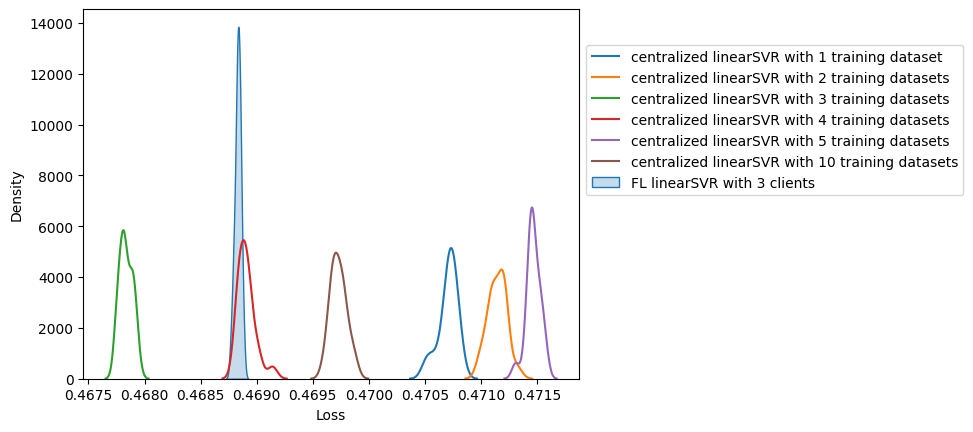

In [72]:
temp_df = baseline_linear_models_only_df[baseline_linear_models_only_df.model == "linearSVR"]

fig = sns.kdeplot(temp_df["client_data1"], label="centralized linearSVR with 1 training dataset")
fig = sns.kdeplot(temp_df["client_data2"], label="centralized linearSVR with 2 training datasets")
fig = sns.kdeplot(temp_df["client_data3"], label="centralized linearSVR with 3 training datasets")
fig = sns.kdeplot(temp_df["client_data4"], label="centralized linearSVR with 4 training datasets")
fig = sns.kdeplot(temp_df["client_data5"], label="centralized linearSVR with 5 training datasets")
fig = sns.kdeplot(temp_df["client_data10"], label="centralized linearSVR with 10 training datasets")
fig = sns.kdeplot(fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"], fill=True, label="FL linearSVR with 3 clients")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xlabel("Loss")

plt.savefig("exports/weather_linearSVR_results.svg")
plt.show()

In [73]:
_, p_value = scipy.stats.mannwhitneyu(temp_df["client_data3"], fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"])

print(p_value)

6.795615128173358e-08


In [75]:
_, p_value = scipy.stats.levene(temp_df["client_data1"], fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"])

print(f"Client 1: {p_value}")

_, p_value = scipy.stats.levene(temp_df["client_data2"], fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"])

print(f"Client 2: {p_value}")

_, p_value = scipy.stats.levene(temp_df["client_data3"], fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"])

print(f"Client 3: {p_value}")

_, p_value = scipy.stats.levene(temp_df["client_data4"], fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"])

print(f"Client 4: {p_value}")

_, p_value = scipy.stats.levene(temp_df["client_data5"], fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"])

print(f"Client 5: {p_value}")

_, p_value = scipy.stats.levene(temp_df["client_data10"], fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]["centralized_loss"])

print(f"Client 10: {p_value}")

Client 1: 0.00895890303527383
Client 2: 0.0001318987529578241
Client 3: 0.0020243207021628947
Client 4: 0.009449389029860174
Client 5: 0.03102324560262489
Client 10: 0.0009002575319592207


In [70]:
temp_df = pd.DataFrame(columns=["model", "loss"])

temp_df2 = fl_linear_models_only_df[fl_linear_models_only_df.model == "linearSVR"]
mean_loss = temp_df2["centralized_loss"].mean()

temp_df = pd.concat([temp_df, pd.DataFrame({"model": "FL linear SVR", "loss": mean_loss}, index=[0])], ignore_index=True)

temp_df2 = fl_linear_models_only_df[fl_linear_models_only_df.model == "linear regression"]
mean_loss = temp_df2["centralized_loss"].mean()

temp_df = pd.concat([temp_df, pd.DataFrame({"model": "FL linear regression", "loss": mean_loss}, index=[0])], ignore_index=True)

for i in range(6):
    models = ["linear regression", "linearSVR"]

    for m in models:
        temp_df2 = baseline_linear_models_only_df[baseline_linear_models_only_df.model == model].copy(deep=True)
        if i == 5:
            temp_df2["model"] = f'baseline {m} with 10 datasets'
            mean_loss = temp_df2[f'client_data10'].mean()
        else:
            temp_df2["model"] = f'baseline {m} with {i+1} datasets'
            mean_loss = temp_df2[f'client_data{i+1}'].mean()

        if i == 5:
            temp_df = pd.concat([temp_df, pd.DataFrame({"model": f'Baseline {m} with 10 datasets', "loss": mean_loss}, index=[0])], ignore_index=True)
        else:
            temp_df = pd.concat([temp_df, pd.DataFrame({"model": f'Baseline {m} with {i+1} datasets', "loss": mean_loss}, index=[0])], ignore_index=True)
    

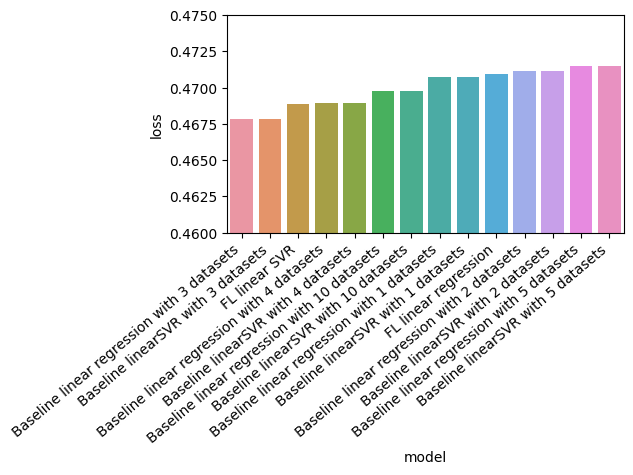

In [71]:
ax = sns.barplot(temp_df, x="model", y="loss", order=temp_df.sort_values('loss')['model'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.ylim(0.46, 0.475)
plt.tight_layout()
plt.show()

Conclusion: FL with optimal parameters (found by trying a bunch of combinations) is not siginificantly different from centralized training.

How do the training times look like?

In [50]:
def calculate_training_time(time_array):
    #get the timestamps
    timestamps = []
    for el in time_array:
        timestamps.append(el[-1])
    
    #calculate difference
    diff = []
    for i in range(len(timestamps)):
        if i == len(timestamps)-1:
            break
        diff.append((timestamps[i+1] - timestamps[i]))
    return diff

time_diff_best_fl_df = best_fl_df.copy(deep=True)
time_diff_best_fl_df["time"] = time_diff_best_fl_df["time"].apply(calculate_training_time)
time_diff_best_fl_df["time"] = time_diff_best_fl_df["time"].apply(lambda x: np.array(x).mean())
time_diff_best_fl_df["model"] = time_diff_best_fl_df["model"].apply(lambda x: f"FL {x}")

In [51]:
baseline_time_df = pd.DataFrame(columns=["model", "time"])

for i in range(1,5):
    temp_df = baseline_df[["model", f"client_time{i}"]].copy(deep=True)
    temp_df["model"] = temp_df["model"].apply(lambda x: "baseline linear regression" if x == "linear_regression" else f"baseline {x}")
    temp_df.columns = ["model", "time"]

    baseline_time_df = pd.concat([baseline_time_df, temp_df], ignore_index=True)

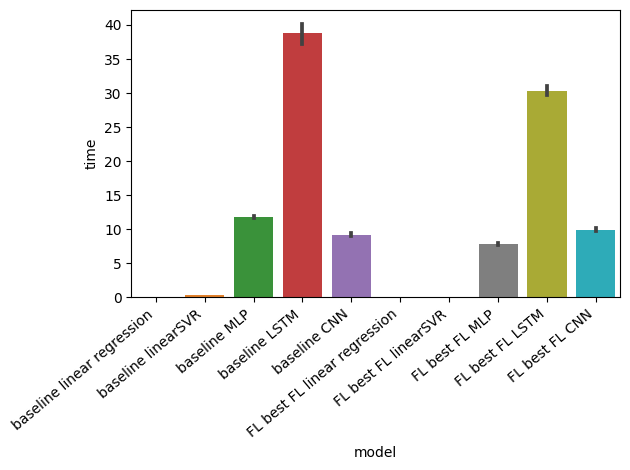

In [52]:
ax = sns.barplot(pd.concat([baseline_time_df, time_diff_best_fl_df], ignore_index=True), y="time", x="model")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Linear regression and linearSVR are almost instantly trained, when compared to the neural networks. The FL scenario seems to be better. But it is important to note that the way of measuring time cannot be implemented the same way for FL and the baselines. Also, this is only a small number of models and therefore not representative for these model architectures.